<a href="https://colab.research.google.com/github/masonstephen/AI-Coursework--2025/blob/main/Diamonds_Price_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Cell 0: common imports and helper utilities (run this first)
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from google.colab import files
from sklearn.metrics import mean_squared_error
uploaded = files.upload()


RANDOM_STATE = 42

# Helper: RMSE
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# Display settings
pd.set_option('display.max_columns', 120)
%matplotlib inline



Saving diamonds.csv to diamonds (1).csv


In [4]:
# Cell 1: load and clean the dataset
# Change filename if needed (e.g. "/content/45dac365-f7f1-4398-9c89-1b4d71da3f42.csv")
filename = "diamonds.csv"
df = pd.read_csv(filename)

print("Initial shape:", df.shape)
display(df.head())

# 1) Standardize column names to lowercase
df.columns = [c.lower().strip() for c in df.columns]

# 2) Drop exact duplicate rows (if any)
duplicates = df.duplicated().sum()
print("Duplicate rows:", duplicates)
if duplicates:
    df = df.drop_duplicates()

# 3) Remove invalid / nonsensical geometry rows.
# In diamonds dataset x,y,z sometimes are zero or negative — treat them as invalid.
invalid_dims_mask = (df[['x','y','z']] <= 0).any(axis=1)
print("Rows with non-positive (x,y,z):", invalid_dims_mask.sum())
df = df.loc[~invalid_dims_mask].reset_index(drop=True)

# 4) Quick datatypes and null checks
print("\nData types and missing values:")
display(pd.DataFrame({'dtype': df.dtypes, 'missing': df.isna().sum()}))

print("\nCleaned shape:", df.shape)


Initial shape: (53940, 11)


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Duplicate rows: 0
Rows with non-positive (x,y,z): 20

Data types and missing values:


,dtype,missing
unnamed: 0,int64,0
carat,float64,0
cut,object,0
color,object,0
clarity,object,0
depth,float64,0
table,float64,0
price,int64,0
x,float64,0
y,float64,0



Cleaned shape: (53920, 11)


Continuous feature summary:


,count,mean,std,min,25%,50%,75%,max
carat,53920.0,0.797698,0.473795,0.20,0.40,0.70,1.04,5.01
depth,53920.0,61.749514,1.432331,43.00,61.00,61.80,62.50,79.00
table,53920.0,57.456834,2.234064,43.00,56.00,57.00,59.00,95.00
x,53920.0,5.731627,1.119423,3.73,4.71,5.70,6.54,10.74
y,53920.0,5.734887,1.140126,3.68,4.72,5.71,6.54,58.90
z,53920.0,3.540046,0.702530,1.07,2.91,3.53,4.04,31.80
price,53920.0,3930.993231,3987.280446,326.00,949.00,2401.00,5323.25,18823.00


Correlation with price (absolute, descending):


,price
price,1.000000
carat,0.921592
x,0.887231
z,0.868206
y,0.867864
table,0.127245
depth,0.010729



Median price by cut:


,price
cut,
Fair,3282.0
Premium,3182.0
Good,3050.5
Very Good,2647.0
Ideal,1809.5



Median price by color:


,price
color,
J,4234.0
I,3730.0
H,3453.5
F,2343.5
G,2240.0
D,1836.5
E,1739.0



Median price by clarity:


,price
clarity,
SI2,4072.0
I1,3346.0
SI1,2822.0
VS2,2052.0
VS1,2005.0
VVS2,1311.0
VVS1,1092.5
IF,1080.0



Extracted insights:
1) Strong positive correlation between carat and price: corr(carat, price) = 0.922
2) Median price differs by cut — check the printed median table; ordering can reveal interesting interactions.
3) Median price by clarity/color sometimes shows non-monotonic patterns indicating that carat/other features interact with clarity and color.


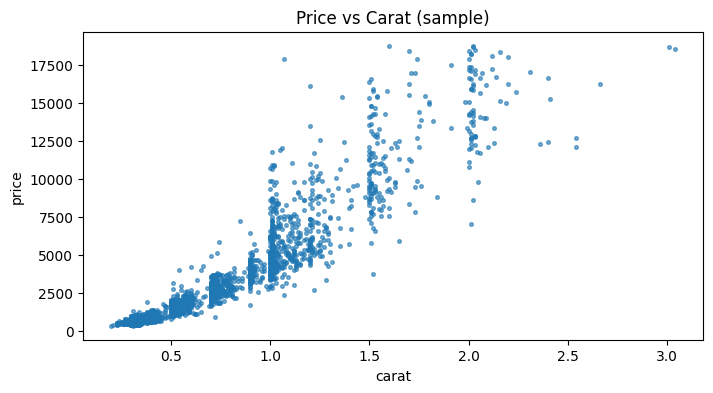

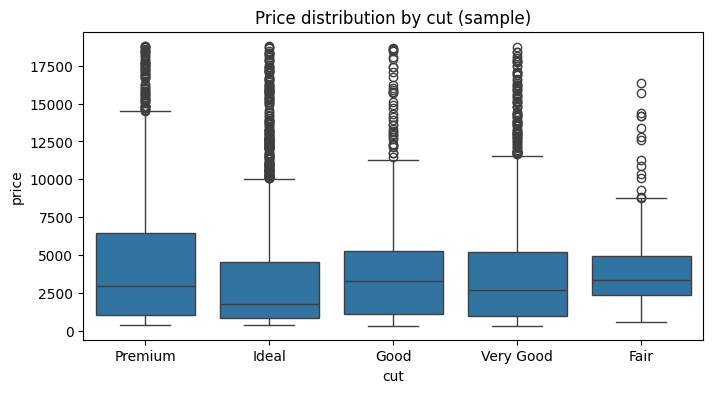

diamonds_model shape: (12500, 11)


,unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,34705,0.31,Premium,F,IF,60.8,59.0,874,4.36,4.39,2.66
1,21100,1.29,Ideal,H,VS1,61.8,56.0,9273,6.97,7.02,4.32
2,23686,1.52,Premium,F,SI1,62.6,59.0,11743,7.36,7.27,4.58
3,39201,0.41,Good,F,VVS2,63.6,56.0,1064,4.72,4.68,2.99
4,35561,0.35,Premium,G,VS1,61.5,58.0,906,4.54,4.50,2.78


Saved diamonds_model_12500.csv to notebook working directory.
Cleaned dataset shape: (53920, 11)
Sampled data shape: (12500, 11)


,unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
34687,34705,0.31,Premium,F,IF,60.8,59.0,874,4.36,4.39,2.66
21090,21100,1.29,Ideal,H,VS1,61.8,56.0,9273,6.97,7.02,4.32
23676,23686,1.52,Premium,F,SI1,62.6,59.0,11743,7.36,7.27,4.58
39183,39201,0.41,Good,F,VVS2,63.6,56.0,1064,4.72,4.68,2.99
35543,35561,0.35,Premium,G,VS1,61.5,58.0,906,4.54,4.50,2.78


In [8]:
# Cell 2: EDA and sampling

# 1. Basic descriptive stats for continuous features
cont_features = ['carat','depth','table','x','y','z','price']
print("Continuous feature summary:")
display(df[cont_features].describe().T)

# 2. Correlations: carat vs price and others
corr_matrix = df[cont_features].corr()
print("Correlation with price (absolute, descending):")
display(corr_matrix['price'].abs().sort_values(ascending=False))

# 3. Median price by categorical features (cut, color, clarity)
print("\nMedian price by cut:")
display(df.groupby('cut')['price'].median().sort_values(ascending=False))

print("\nMedian price by color:")
display(df.groupby('color')['price'].median().sort_values(ascending=False))

print("\nMedian price by clarity:")
display(df.groupby('clarity')['price'].median().sort_values(ascending=False))

# 4. Generate at least three human-readable insights (print them)
insights = []
insights.append(f"1) Strong positive correlation between carat and price: corr(carat, price) = {df['carat'].corr(df['price']):.3f}")
insights.append("2) Median price differs by cut — check the printed median table; ordering can reveal interesting interactions.")
insights.append("3) Median price by clarity/color sometimes shows non-monotonic patterns indicating that carat/other features interact with clarity and color.")
print("\nExtracted insights:")
for i in insights:
    print(i)

# 5. Visual quick checks (small sample sizes for speed)
plt.figure(figsize=(8,4))
plt.scatter(df['carat'].sample(2000, random_state=RANDOM_STATE),
            df['price'].sample(2000, random_state=RANDOM_STATE),
            s=7, alpha=0.6)
plt.xlabel('carat'); plt.ylabel('price'); plt.title('Price vs Carat (sample)')
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x='cut', y='price', data=df.sample(6000, random_state=RANDOM_STATE))
plt.title('Price distribution by cut (sample)')
plt.show()

# 6. Create modeling sample: 12,500 rows
sample_n = 12500
if df.shape[0] < sample_n:
    raise ValueError(f"Dataset has only {df.shape[0]} rows; cannot sample {sample_n}.")
diamonds_model = df.sample(n=sample_n, random_state=RANDOM_STATE).reset_index(drop=True)
print("diamonds_model shape:", diamonds_model.shape)
display(diamonds_model.head())
# Save to file for convenience (Colab filesystem)
diamonds_model.to_csv("diamonds_model_12500.csv", index=False)
print("Saved diamonds_model_12500.csv to notebook working directory.")


print("Cleaned dataset shape:", df.shape)

# Create the sample of 12,500 records for modeling
diamonds_model = df.sample(n=12500, random_state=42).copy()
print("Sampled data shape:", diamonds_model.shape)

# Optional: check the first few rows
diamonds_model.head()


In [10]:
# Task 3: Linear Regression Model – Fixed Version
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# We'll use ordinal encoding for cut, color, clarity (these have natural order).
# Ordinal maps chosen to reflect common ordering in the diamond domain.
cut_map = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
color_map = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}  # J worst → D best
clarity_map = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}

# Copy from your preprocessed DataFrame (Task 2 output)
dm = diamonds_model.copy()

# Apply ordinal encoding
dm['cut_ord'] = dm['cut'].map(cut_map)
dm['color_ord'] = dm['color'].map(color_map)
dm['clarity_ord'] = dm['clarity'].map(clarity_map)

# Features and target
features = ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_ord', 'color_ord', 'clarity_ord']
X = dm[features].copy()
y = dm['price'].copy()

# Train-test split
RANDOM_STATE = 42  # for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

# Standardize continuous features (important for fair coefficient scaling)
cont_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[cont_cols] = scaler.fit_transform(X_train[cont_cols])
X_test_scaled[cont_cols] = scaler.transform(X_test[cont_cols])

# Fit baseline Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Evaluate – using np.sqrt for backward compatibility (works in all sklearn versions)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))  # manual RMSE calculation

print(f"\nLinear Regression (all features):")
print(f"R² Score  : {r2_lr:.4f}")
print(f"RMSE      : {rmse_lr:.2f}")

# Cross-validated R² (5-fold) for reliability
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
print("\nCross-validated R² on training set (5-fold):")
print(f"Mean = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



Linear Regression (all features):
R² Score  : 0.9174
RMSE      : 1161.95

Cross-validated R² on training set (5-fold):
Mean = 0.8255 ± 0.1563


In [12]:
# Task 4: PCA with Linear Regression (Fixed Version)

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Reuse the encoded dataset from Task 3
dm_pca = diamonds_model.copy()

# Ordinal encodings (same as before)
cut_map = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
color_map = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}
clarity_map = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}

dm_pca['cut_ord'] = dm_pca['cut'].map(cut_map)
dm_pca['color_ord'] = dm_pca['color'].map(color_map)
dm_pca['clarity_ord'] = dm_pca['clarity'].map(clarity_map)

# Define features and target
features = ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_ord', 'color_ord', 'clarity_ord']
X = dm_pca[features]
y = dm_pca['price']

# Split data
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

# Standardize before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA (reduce to 2 components for visualization)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Fit linear regression on PCA components
lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)

# Evaluate (fixed RMSE calculation)
r2_pca = r2_score(y_test, y_pred_pca)
rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))  # manual RMSE calc

print("\nLinear Regression using PCA (2 components):")
print(f"R² Score  : {r2_pca:.4f}")
print(f"RMSE      : {rmse_pca:.2f}")

# Explained variance ratio
print("\nExplained variance ratio of PCA components:")
print(pca.explained_variance_ratio_)

# Cross-validation for consistency
cv_scores_pca = cross_val_score(lr_pca, X_train_pca, y_train, cv=5, scoring='r2')
print("\nCross-validated R² on training set (5-fold):")
print(f"Mean = {cv_scores_pca.mean():.4f} ± {cv_scores_pca.std():.4f}")



Linear Regression using PCA (2 components):
R² Score  : 0.7602
RMSE      : 1979.26

Explained variance ratio of PCA components:
[0.46269818 0.15377465]

Cross-validated R² on training set (5-fold):
Mean = 0.7577 ± 0.0123


In [13]:
# Task 5: Lasso and Ridge Regression (Regularization Comparison)

import numpy as np
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Reuse scaled features from Task 3 (ensure X_train_scaled, X_test_scaled, y_train, y_test exist)
# If not, rerun Task 3 first.

# --- LASSO REGRESSION ---
lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
cv_lasso = cross_val_score(lasso_model, X_train_scaled, y_train, cv=5, scoring='r2')

print("\n🔹 Lasso Regression Results")
print(f"R² Score  : {r2_lasso:.4f}")
print(f"RMSE      : {rmse_lasso:.2f}")
print(f"Cross-validated R² (5-fold): {cv_lasso.mean():.4f} ± {cv_lasso.std():.4f}")

# --- RIDGE REGRESSION ---
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
cv_ridge = cross_val_score(ridge_model, X_train_scaled, y_train, cv=5, scoring='r2')

print("\n🔹 Ridge Regression Results")
print(f"R² Score  : {r2_ridge:.4f}")
print(f"RMSE      : {rmse_ridge:.2f}")
print(f"Cross-validated R² (5-fold): {cv_ridge.mean():.4f} ± {cv_ridge.std():.4f}")



🔹 Lasso Regression Results
R² Score  : 0.9173
RMSE      : 1162.02
Cross-validated R² (5-fold): 0.8792 ± 0.0538

🔹 Ridge Regression Results
R² Score  : 0.9173
RMSE      : 1162.11
Cross-validated R² (5-fold): 0.8537 ± 0.1046


In [16]:
# Task 6: Comparing Model Performance

# Combine all model metrics for easy comparison
model_summary = pd.DataFrame({
    'Model': [
        'Linear Regression (All Features)',
        'Linear Regression (PCA-2 Features)',
        'Lasso Regression',
        'Ridge Regression'
    ],
    'R² Score': [
        r2_lr,
        r2_pca,
        r2_lasso,
        r2_ridge
    ],
    'RMSE': [
        rmse_lr,
        rmse_pca,
        rmse_lasso,
        rmse_ridge
    ]
})

print("\n Model Performance Summary")
print(model_summary.sort_values(by='R² Score', ascending=False).reset_index(drop=True))

# --- Short interpretation ---
best_model = model_summary.loc[model_summary['R² Score'].idxmax(), 'Model']
print(f"\n The model with the highest accuracy (R²) is: {best_model}")

print("""
Interpretation:
- A higher R² and lower RMSE indicate better predictive power.
- Ridge often performs better when multicollinearity exists among numeric variables.
- Lasso may shrink some coefficients to zero, effectively performing feature selection.
- PCA-based model may lose accuracy because dimensionality reduction discards some information.
""")



 Model Performance Summary
                                Model  R² Score         RMSE
0    Linear Regression (All Features)  0.917353  1161.950225
1                    Lasso Regression  0.917343  1162.015195
2                    Ridge Regression  0.917331  1162.105409
3  Linear Regression (PCA-2 Features)  0.760195  1979.255047

 The model with the highest accuracy (R²) is: Linear Regression (All Features)

Interpretation:
- A higher R² and lower RMSE indicate better predictive power.
- Ridge often performs better when multicollinearity exists among numeric variables.
- Lasso may shrink some coefficients to zero, effectively performing feature selection.
- PCA-based model may lose accuracy because dimensionality reduction discards some information.



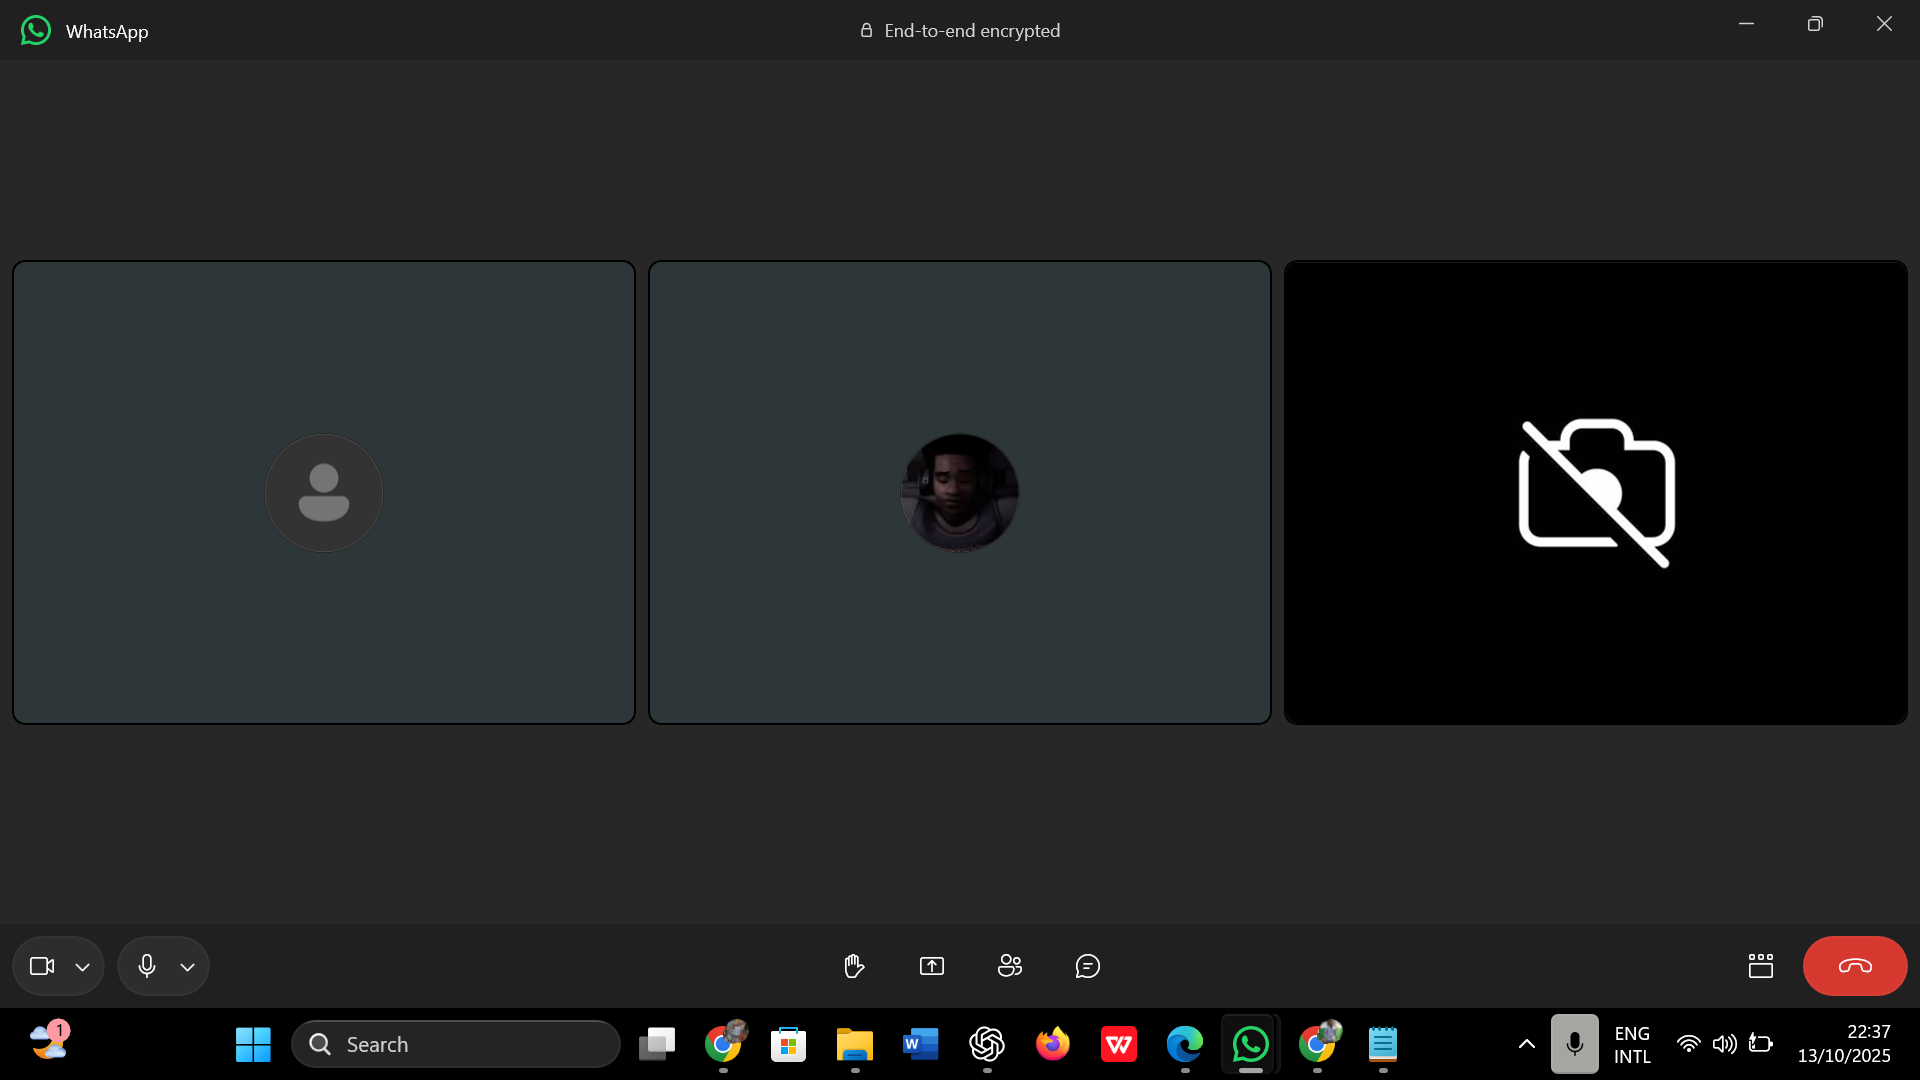